In [47]:
import numpy as np
import pandas as pd
from DataProcessing import Data

# 1. Get Data 

## 1.1. Get Data from folder

In [48]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [49]:
chosen_index = 'ORCL'

In [50]:
d.preprocess(chosen_index)

Processing ORCL.csv
Saved ORCL data at data/processed/ORCL.csv


In [51]:
df = d.get_data(chosen_index)

In [52]:
df.head

<bound method NDFrame.head of             Date        Open        High         Low       Close    Volume  \
0     2019-04-01   49.646237   50.355732   49.618592   50.291233  15191700   
1     2019-04-02   50.134584   50.217512   49.646231   49.895016  10812100   
2     2019-04-03   49.904233   50.116159   49.627807   49.812092  12853400   
3     2019-04-04   49.627808   49.895021   49.213167   49.590950   9978800   
4     2019-04-05   49.517238   49.931875   49.517238   49.692307  10016300   
...          ...         ...         ...         ...         ...       ...   
1240  2024-03-05  112.820000  113.199997  110.370003  110.940002   8242000   
1241  2024-03-06  111.500000  113.050003  110.669998  112.269997   6706400   
1242  2024-03-07  113.940002  114.800003  112.290001  114.540001   7670100   
1243  2024-03-08  114.070000  114.330002  111.540001  112.419998   8304100   
1244  2024-03-11  111.610001  114.750000  111.180000  114.129997  19797400   

            RSI        MFI       

In [53]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MFI', 'EMA',
       'SO', 'MACD', 'Next Day Price'],
      dtype='object')

# 2. Train model

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import  train_test_split

In [55]:
X = df[df.columns[1:10]].values
Y = df[df.columns[10]].values

## 2.1. Split data

### 2.1.2. Unchronologically

In [56]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=37)

### 2.1.2. Chronologically

In [57]:
TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

## 2.2. Train model

In [58]:
from helper import prepare_data
from sklearn.model_selection import GridSearchCV


def train_model(index):
    X_train, Y_train, X_test, Y_test = prepare_data(index)

    model = GradientBoostingRegressor()

    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.2, 0.05],
        'subsample': [0.86, 0.85,  0.87],
        #'max_depth': [1, 2, 3]
    }

    model = GridSearchCV(model, param_grid, cv = 3, n_jobs = -1, verbose = 2)
    model.fit(X_train,Y_train)
    print("Best parameters found: ", model.best_params_)
    model.score(X_test,Y_test)
    return model

model = train_model(chosen_index)

X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.87}


## Plot Result

In [59]:
import matplotlib.pyplot as plt

In [60]:
Y_predict = model.predict(X_test)

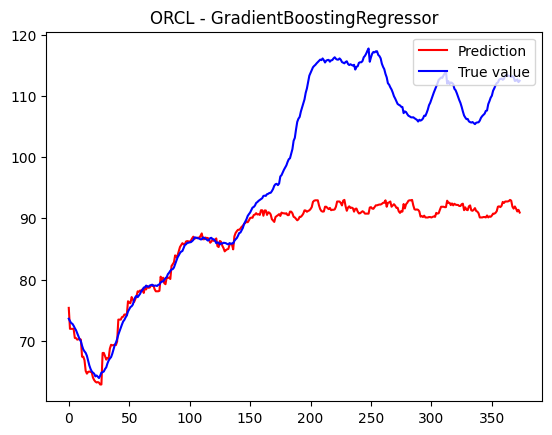

In [61]:
plt.plot(Y_predict,color='red',label='Prediction')
plt.plot(Y_test,color='blue',label='True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - GradientBoostingRegressor')
plt.show()

## Save results

In [62]:
import time
from helper import calculate_loss, prepare_data

mae = []
mse = []
r2 = []
rmse = []
mape = []
avg_runtime = 0

list_tickers = d.get_sp500_tickers()
# track run time

for ticker in list_tickers:
    start = time.time()
    X_train, Y_train, X_test, Y_test = prepare_data(ticker)

    # call model
    model = train_model(ticker)

    # predictions = model.predict(X_test)
    mse_, r2_, rmse_, mape_, mae_ = calculate_loss(model, X_test, Y_test)
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    rmse.append(rmse_)
    mape.append(mape_)

    end = time.time()
    avg_runtime += (end-start)

mae = np.mean(list(mae))
mse = np.mean(list(mse))
r2 = np.mean(list(r2))
rmse = np.mean(list(rmse))
mape = np.mean(list(mape))
avg_runtime = avg_runtime/len(list_tickers)

with open('output/evaluation.csv', 'a') as f:
    f.write(f'Gradient Boosting,{mae},{mse},{r2},{rmse},{mape},{avg_runtime}\n')

X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.85}
Calculating loss for model GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.05],
                         'max_depth': [1, 2, 3], 'n_estimators': [100],
                         'subsample': [0.86, 0.85, 0.87]},
             verbose=2)...
Mean Squared Error: 177.6120481738922
R-squared: -0.4192392072554523
Root Mean Squared Error: 13.327117024093853
Mean Absolute Percentage Error: 0.06052099248263677
Mean Absolute Error: 11.178446885171343
X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
Fitting 3 folds for each of 27 candidates